# EDA

下記ステップを踏んで進める．

1. 問題を理解する
2. 目的変数(SalePrice)を調べる
3. 説明変数と目的変数の相関を調べる
4. 簡単な前処理
  - 欠損値
  - 外れ値
  - categorical data
5. 仮定の確認


参照:
- [COMPREHENSIVE DATA EXPLORATION WITH PYTHON | Kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
- 問題: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_feather('../data/input/train.feather')

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1. So... What can we expect?

EDA を行うことで，簡単な仮説を立てる．
そのために下記を理解する．
これをスプレッドシートにまとめてみるとよい．

- Variable
- Type: numerical / categorical
- Segment: building / space / location
- Expectation: その変数が目的変数にどの程度影響しそうか．主観的な予測．high / medium / low
- Conclusion
- Comments

Expectation については下記に注意する．

- 実際に自分が家を買うとして，その変数を考慮するか
- もしそうなら，どの程度重要と考えるか
- その情報は別の変数に含まれていないか

結果，下記の要素が重要と判断した．

- MSSubClass(categorical)
- LotArea(numerial)
- LandContour(categorical)
- BldgType(categorical)
- OverallQual(categorical)
- YearBuilt(categorical)
- TotalBsmtSF(numerical)
- PoolArea(numerical)
- MiscVal(numerical)

data/input/eda_expectation.csv に保存した．
このうち，扱いやすさから，numerical data についてみていく．

## 2. First things first: analysing 'SalePrice'

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

とりあえず，最小値が 0 より大きいことがわかり，おそらく間違いのないデータと思われる．

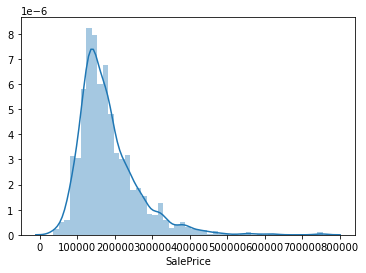

In [5]:
sns.distplot(df_train['SalePrice'])

このグラフからわかることは以下のとおり．

- 正規分布ではない
- かなり正の歪度がある
- 尖っている

In [6]:
print('Skewness: {s:.3f}'.format(s=df_train['SalePrice'].skew()))
print('Kurtosis: {k:.3f}'.format(k=df_train['SalePrice'].kurt()))

Skewness: 1.883
Kurtosis: 6.536


注)  

Skewness: 歪度(3 次のモーメント)  

$\alpha_3 = E(X - \mu)^3 / \sigma^3$  

- $\alpha_3 < 0$: 左の裾が長い
- $\alpha_3 > 0$: 右の裾が長い

Kurtosis: 尖度(4 次のモーメント)  

$\alpha_4 = E(X - \mu)^4 / \sigma^4$  

- $\alpha_4 < 0$: 正規分布の方が尖っている
- $\alpha_4 > 0$: 正規分布より尖っている

### Numerical データとの関係

相関を調べてみる．  

先程，重要と推測した下記変数のうち，numerical データとの相関を調べる．

- LotArea(numerial)
- TotalBsmtSF(numerical)
- PoolArea(numerical)
- MiscVal(numerical)

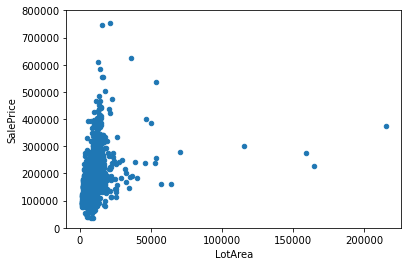

In [7]:
var = 'LotArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

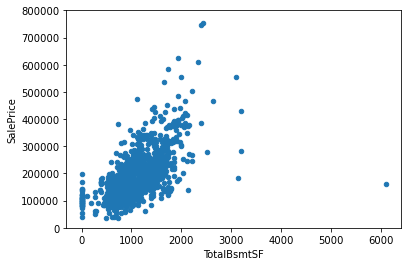

In [8]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

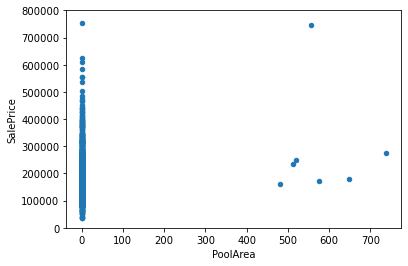

In [9]:
var = 'PoolArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

PoolArea: 関係ない

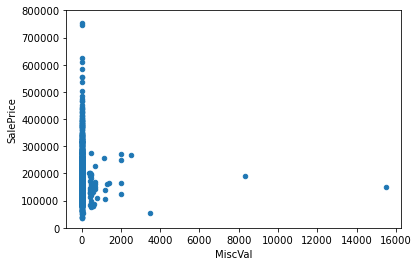

In [10]:
var = 'MiscVal'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

MiscVal: 関係ない

### Categorical データとの関係

相関を調べてみる．  

先程，重要と推測した下記変数のうち，categorical データとの相関を調べる．

- MSSubClass(categorical)
- LandContour(categorical)
- BldgType(categorical)
- OverallQual(categorical)
- YearBuilt(categorical)

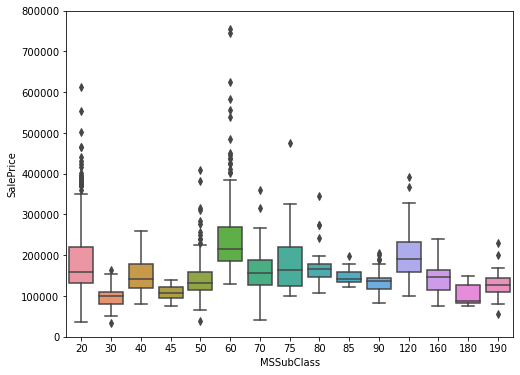

In [11]:
var = 'MSSubClass'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

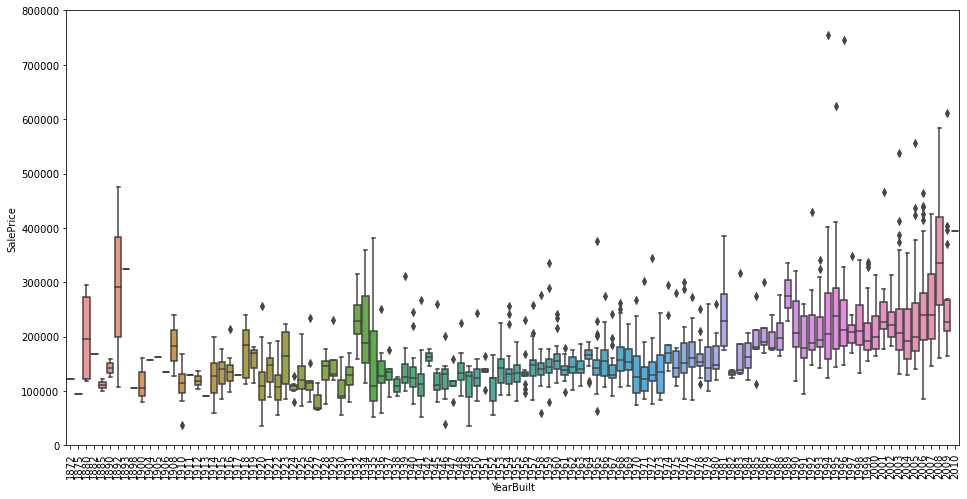

In [12]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

新しい方が高い傾向があると言えそう．

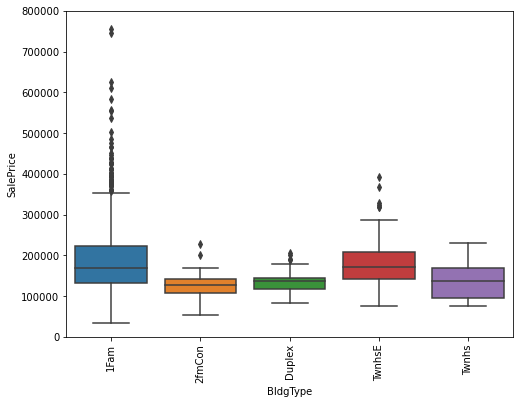

In [13]:
var = 'BldgType'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

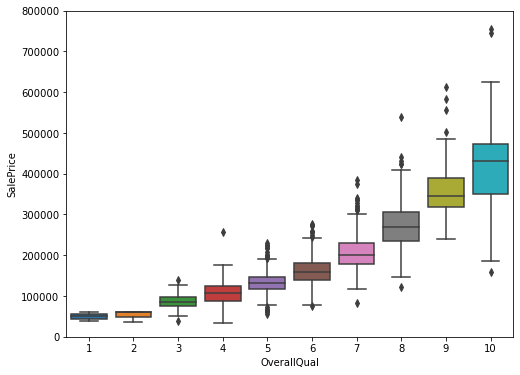

In [14]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

### まとめ

説明変数として下記が使えそう．

- numerical data
  - TotalBsmtSF
- categorical data
  - YearBuilt
  - OverallQual

## 3. Keep calm and work smart

ここまで，主観的な分析を行ってきた．ここから客観的な分析を行う．

概観するため，以下を作ってみる．

- Correlation matrix (heatmap style).
- 'SalePrice' correlation matrix (zoomed heatmap style).
- Scatter plots between the most correlated variables (move like Jagger style).

### Correlation matrix

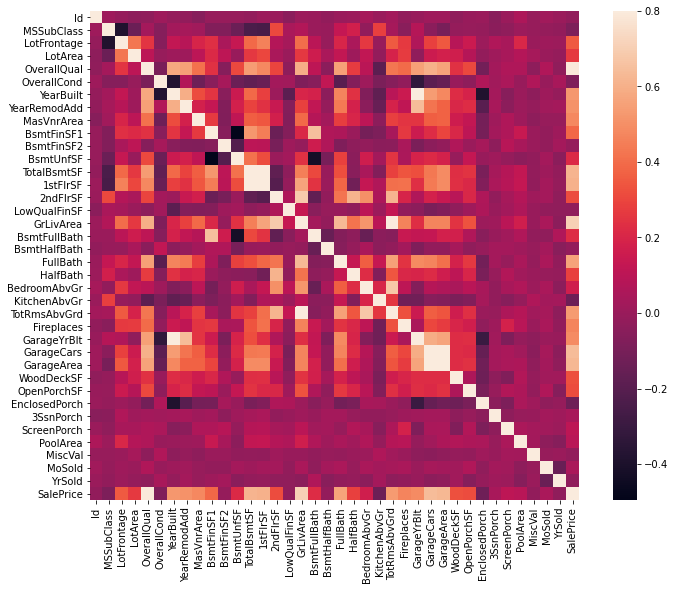

In [15]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

ヒートマップから以下のことがわかる．

変数間の相関について，以下の組の相関が高いことがわかる．

- (TotalBsmtSF, 1stFlrSF)
- (GarageYrBlt, GarageCars, GarageArea)

また，SalePrics との相関について，下記変数と相関が高いことがわかる．

- OverallQual: Rates the overall material and finish of the house
- GrLivArea: Above grade (ground) living area square feet
- TotalBsmtSF: Total square feet of basement area

上記以外に重要と思われる変数を見ていく．

### 'SalePrice' correlation matrix

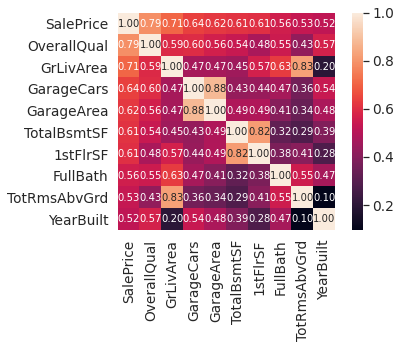

In [24]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

下記は比較的相関が強い．

- OverallQual
- GrLivArea
- CarageArea
- TotalBsmtSF

下記は本当に相関が強いのか？

- FullBath

また，下記は多少相関がある．

- YearBuilt

時系列データなので，とりあえず除外して考える．

### Scatter plots between the most correlated variables

## 4. Missing data

## 5. Getting hard core

## 6. Conclusion

In [16]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [17]:
df_train.shape

(1460, 81)

In [18]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Missing Value

In [19]:
df_train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

LotFrontage は，物件に面する道の長さ．
`drop()` してみる．

In [20]:
df_train = df_train.drop(columns=['LotFrontage'])

In [21]:
df_train.shape

(1460, 80)